# R code for generating xxx

This notebook contains code for generating the 10%/90% quantile boundaries for Figure 8
of the paper, using a LOESS approach to get smooth boundaries. It makes use of an algorithm
from Sakov et al. (2010), as implemented in R by Tal Galili (see below for links).

The output data files can be found in the data/ subdirectory, and are read in and plotted
in the Python notebook `s4gbars_barsizes.ipynb`.

In [2]:
library(zoo)


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



### Quantile LOESS function

In [4]:
# Quantile LOESS function by Tal Galili
# The code was published on: http://www.r-statistics.com/2010/04/quantile-lowess-combining-a-moving-quantile-window-with-lowess-r-function
# Based on the algorithm published here: http://www.e-publications.org/ims/submission/index.php/AOAS/user/submissionFile/4295?confirm=37ca4b72
# http://en.wikipedia.org/wiki/Moving_average

Quantile.loess	 <- function(Y, X = NULL, 
							number.of.splits = NULL,
							window.size = 20,
							percent.of.overlap.between.two.windows = NULL,
							the.distance.between.each.window = NULL,
							the.quant = .95,
							window.alignment = c("center"), 
							window.function = function(x) {quantile(x, the.quant)},
							...)
{
	# input: Y and X, and smothing parameters
	# output: new y and x
	
	# Extra parameter "..." goes to the loess	
	
	# window.size ==  the number of observation in the window (not the window length!)

	# "number.of.splits" will override "window.size"
	# let's compute the window.size:	
	if(!is.null(number.of.splits)) {window.size <- ceiling(length(Y)/number.of.splits)}

	# If the.distance.between.each.window is not specified, let's make the distances fully distinct
	if(is.null(the.distance.between.each.window)) {the.distance.between.each.window <- window.size}
	
	# If percent.of.overlap.between.windows is not null, it will override the.distance.between.each.window 
	if(!is.null(percent.of.overlap.between.two.windows)) 
		{
			the.distance.between.each.window <- window.size * (1-percent.of.overlap.between.two.windows)
		}
	
	
	
	# loading zoo
	if(!require(zoo)) 	
	{
		print("zoo is not installed - please install it.")
		install.packages("zoo")
	}

	

	if(is.null(X)) {X <- index(Y)} # if we don't have any X, then Y must be ordered, in which case, we can use the indexes of Y as X.

	# creating our new X and Y
	zoo.Y <- zoo(x = Y, order.by = X)
	#zoo.X <- attributes(zoo.Y)$index

	new.Y <- rollapply(zoo.Y, width = window.size, 
								FUN = window.function,
								by = the.distance.between.each.window,
								align = window.alignment)
	new.X <- attributes(new.Y)$index
	
	new.Y.loess <- loess(new.Y~new.X, family = "sym", ...)$fitted 
	
	return(list(y = new.Y, x = new.X, y.loess = new.Y.loess))
}


## S4G bar sizes

Warning message in zoo(x = Y, order.by = X):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”Warning message in zoo(x = Y, order.by = X):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”

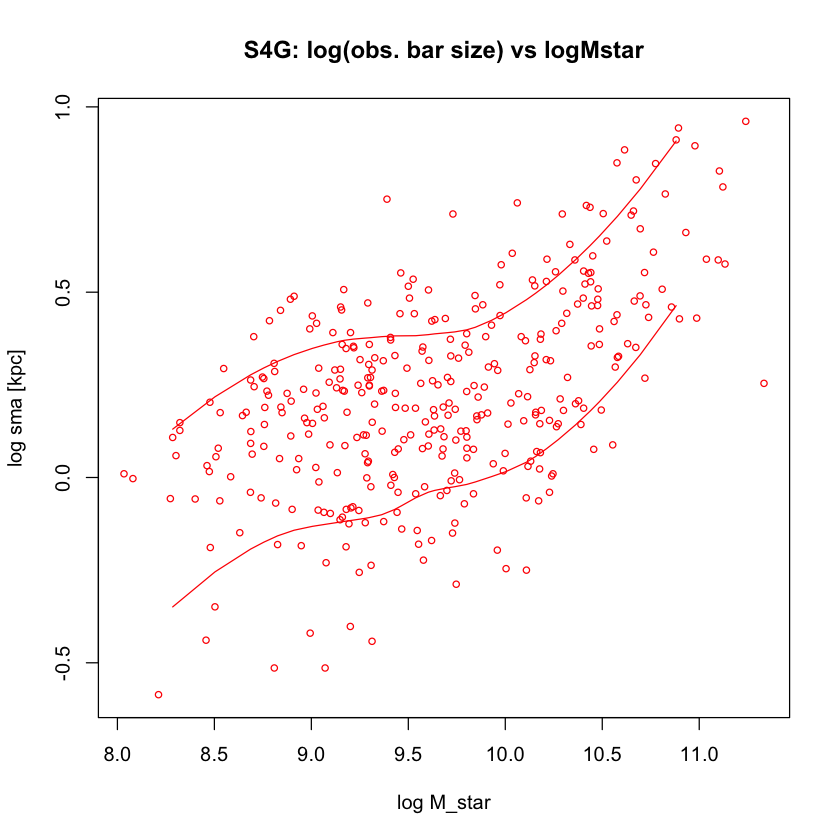

In [7]:
# *** Running median and quantiles plots for observed bar sizes

# * S4G data (D < 25 Mpc)

basedir <- "/Users/erwin/Documents/Working/Projects/Project_BarSizes/"
ff <- paste(basedir, "obs-barsize-vs-logmstar_sample1_for-R_sorted.txt", sep="")
logMstarSmaTable <- read.table(ff, header=TRUE)

plot(logMstarSmaTable$logmstar, logMstarSmaTable$log_sma_kpc, main="S4G: log(obs. bar size) vs logMstar", col='red', cex=0.7, xlab='log M_star',ylab='log sma [kpc]')

QL_90 <- Quantile.loess(Y=logMstarSmaTable$log_sma_kpc, X = logMstarSmaTable$logmstar, the.quant=.9, window.size = 10, window.alignment = c("center"))
QL_10 <- Quantile.loess(Y=logMstarSmaTable$log_sma_kpc, X = logMstarSmaTable$logmstar, the.quant=.1, window.size = 10, window.alignment = c("center"))
points(QL_90$y.loess ~ QL_90$x, type = "l", col = "red")
points(QL_10$y.loess ~ QL_10$x, type = "l", col = "red")

# uncomment the following to save the tables (will overwrite existing files)
#zz <- matrix(c(QL_10$x,QL_10$y.loess), ncol=2)
#write(t(zz), file="./data/s4g_barsizes_10percentile.txt", ncolumns=2)
#zz <- matrix(c(QL_90$x,QL_90$y.loess), ncol=2)
#write(t(zz), file="./data/s4g_barsizes_90percentile.txt", ncolumns=2)

## Hoyle+2011 GZ2 bar sizes

Warning message in zoo(x = Y, order.by = X):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”Warning message in zoo(x = Y, order.by = X):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”

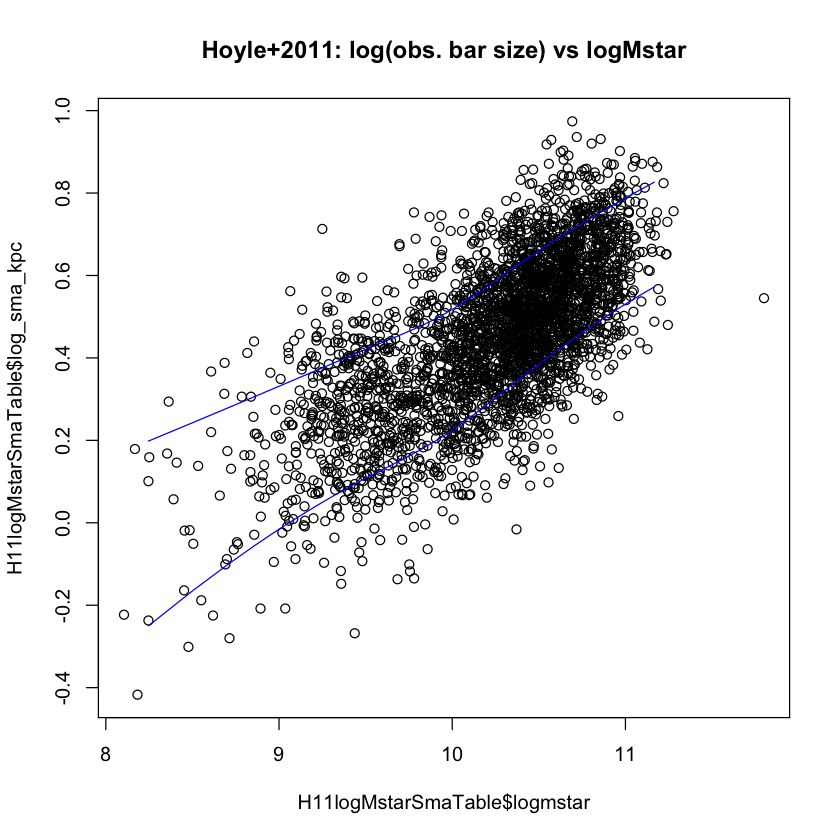

In [8]:
basedir <- "/Users/erwin/Documents/Working/Projects/Project_BarSizes/"
ff <- paste(basedir, "obs-barsize-vs-logmstar_Hoyle+2011_for-R_sorted.txt", sep="")
H11logMstarSmaTable <- read.table(ff, header=TRUE)

plot(H11logMstarSmaTable$logmstar, H11logMstarSmaTable$log_sma_kpc, main="Hoyle+2011: log(obs. bar size) vs logMstar")

h11QL_90 <- Quantile.loess(Y=H11logMstarSmaTable$log_sma_kpc, X = H11logMstarSmaTable$logmstar, the.quant=.9, window.size = 10, window.alignment = c("center"))
h11QL_10 <- Quantile.loess(Y=H11logMstarSmaTable$log_sma_kpc, X = H11logMstarSmaTable$logmstar, the.quant=.1, window.size = 10, window.alignment = c("center"))
points(h11QL_90$y.loess ~ h11QL_90$x, type = "l", col = "blue")
points(h11QL_10$y.loess ~ h11QL_10$x, type = "l", col = "blue")

# uncomment the following to save the tables (will overwrite existing files)
#zz <- matrix(c(h11QL_10$x,h11QL_10$y.loess), ncol=2)
#write(t(zz), file="./data/hoyle+11_gz2_barsizes_10percentile.txt", ncolumns=2)
#zz <- matrix(c(h11QL_90$x,h11QL_90$y.loess), ncol=2)
#write(t(zz), file="./data/hoyle+11_gz2_barsizes_90percentile.txt", ncolumns=2)